# Recurrency Metric for the tgbl-comment dataset

This notebook explores a recurrency metric for the tgbl-comment dataset based on how often interaction between pairs of source and destination occur. It splits the interactions in groups based on frequncy of recurrence - 1 day, 1 week, 1 month etc. 

### Dataset Preparation

In [19]:
from TGB.tgb.linkproppred.dataset import LinkPropPredDataset
import pandas as pd

In [20]:
name = "tgbl-comment"
dataset = LinkPropPredDataset(name=name, root="./Datasets", preprocess=True)
data = dataset.full_data

data_df = pd.DataFrame([data['sources'], data['destinations'], data['timestamps']]).T
data_df.columns = ['Source', 'Destination', 'Timestamp']

raw file found, skipping download
Dataset directory is  /opt/homebrew/lib/python3.11/site-packages/tgb/./Datasets/tgbl_comment
loading processed file


KeyboardInterrupt: 

In [3]:
data_df

,Source,Destination,Timestamp
0,0.0,0.0,1.134365e+09
1,1.0,1.0,1.134366e+09
2,2.0,3.0,1.134368e+09
3,4.0,4.0,1.134371e+09
4,5.0,5.0,1.134372e+09
...,...,...,...
44314502,270407.0,970235.0,1.293840e+09
44314503,307508.0,178151.0,1.293840e+09
44314504,609052.0,199010.0,1.293840e+09
44314505,906272.0,1643.0,1.293840e+09


### Recurrency Metric based on Interaction Frequency

In [ ]:
data_df['Timestamp'] = pd.to_datetime(data_df['Timestamp'], unit='s')

In [ ]:
data_df['Year'] = data_df['Timestamp'].dt.year
most_common_year = data_df['Year'].value_counts().idxmax()

start_date = pd.Timestamp(year=most_common_year, month=1, day=1)
end_date = pd.Timestamp(year=most_common_year, month=6, day=30)
df_filtered = data_df[(data_df['Timestamp'] >= start_date) & (data_df['Timestamp'] <= end_date)]

df_filtered['YearWeek'] = df_filtered['Timestamp'].dt.to_period('W')

def check_weekly_occurrences(group):
    expected_weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON').nunique()
    unique_weeks = group['YearWeek'].nunique()
    return unique_weeks == expected_weeks / 2

weekly_occurrences = df_filtered.groupby(['Source', 'Destination']).filter(check_weekly_occurrences)

summary = weekly_occurrences.drop_duplicates(subset=['Source', 'Destination'])

print(f"Year with the most records: {most_common_year}")
print(summary)


/var/folders/j9/gr3m7ly52mx4hfzpzdtzzfg40000gn/T/ipykernel_91215/2341409907.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['YearWeek'] = df_filtered['Timestamp'].dt.to_period('W')


Year with the most records: 2010
            Source  Destination           Timestamp  Year  \
15466202  105954.0     105954.0 2010-01-01 00:04:24  2010   
15469791  129858.0     129858.0 2010-01-01 02:03:07  2010   
15470966  125388.0     320215.0 2010-01-01 02:47:35  2010   
15471914   52237.0      52237.0 2010-01-01 03:28:35  2010   
15472685   63541.0      63541.0 2010-01-01 04:02:43  2010   
...            ...          ...                 ...   ...   
20241505  210090.0     455378.0 2010-03-26 01:07:27  2010   
20640650  247710.0     538817.0 2010-04-01 15:11:11  2010   
20843279  538817.0     538817.0 2010-04-05 15:52:17  2010   
20864278  232399.0     538817.0 2010-04-05 21:19:17  2010   
20971744  545722.0     545722.0 2010-04-07 14:27:14  2010   

                       YearWeek  
15466202  2009-12-28/2010-01-03  
15469791  2009-12-28/2010-01-03  
15470966  2009-12-28/2010-01-03  
15471914  2009-12-28/2010-01-03  
15472685  2009-12-28/2010-01-03  
...                         ..

In [ ]:
frequency = data_df.groupby(['Source', 'Destination'])['Timestamp'].transform(classify_frequency)
data_df['Frequency'] = frequency


In [ ]:
data_df

,Source,Destination,Timestamp,Frequency
0,0.0,1.0,1999-06-13,Single occurrence
1,2.0,3.0,1999-07-01,Single occurrence
2,4.0,1.0,1999-07-13,Single occurrence
3,5.0,6.0,1999-07-13,Single occurrence
4,7.0,8.0,1999-07-13,Single occurrence
...,...,...,...,...
4873535,257355.0,234180.0,2018-10-02,Single occurrence
4873536,195919.0,301073.0,2018-10-03,Single occurrence
4873537,143936.0,137681.0,2018-10-03,Single occurrence
4873538,70003.0,249788.0,2018-10-04,Single occurrence


Now obtain only pairs that have daily interactions

In [23]:
daily_occurrences = data_df[data_df['Frequency'] == 'Daily']

In [24]:
daily_occurrences

,Source,Destination,Timestamp,Frequency
587,669.0,185.0,2000-08-01,Daily
588,669.0,100.0,2000-08-01,Daily
589,669.0,185.0,2000-08-01,Daily
590,669.0,100.0,2000-08-01,Daily
664,669.0,560.0,2000-08-17,Daily
...,...,...,...,...
4871920,154555.0,308688.0,2018-09-11,Daily
4871922,154555.0,308688.0,2018-09-11,Daily
4871923,154555.0,308688.0,2018-09-11,Daily
4871924,154555.0,308688.0,2018-09-11,Daily


In [25]:
daily_occurrences.to_csv('datasets/tgbl-comment_daily_occurrences.csv', index=False)


### Measure average period based on sequence length

In [55]:
import numpy as np

def compute_timeframe(dataset, seq_length, sample_size=100):
    dataset['Timestamp'] = pd.to_numeric(dataset['Timestamp'])

    unique_pairs = dataset[['Source', 'Destination']].drop_duplicates()
    if len(unique_pairs) > sample_size:
        sampled_pairs = unique_pairs.sample(n=sample_size, random_state=1)
    else:
        sampled_pairs = unique_pairs

    all_periods = []

    for _, pair in sampled_pairs.iterrows():
        source = pair['Source']
        destination = pair['Destination']

        direct_interactions = dataset[((dataset['Source'] == source) & (dataset['Destination'] != destination)) |
                                      ((dataset['Destination'] == destination) & (dataset['Source'] != source))]

        latest_interaction_time = dataset[((dataset['Source'] == source) & (dataset['Destination'] == destination))]['Timestamp'].max()
        past_interactions = direct_interactions[direct_interactions['Timestamp'] < latest_interaction_time]

        if len(past_interactions) > seq_length:
            oldest_interaction_timestamp = past_interactions['Timestamp'].min()
            cur_period = latest_interaction_time - oldest_interaction_timestamp
            all_periods.append(cur_period)

    avg = np.mean(all_periods) if all_periods else 0

    total_seconds = avg / 1000

    days = int(total_seconds // (3600 * 24))
    hours = int((total_seconds % (3600 * 24)) // 3600)
    minutes = int((total_seconds % 3600) // 60)

    return f'{days} days, {hours} hours, {minutes} minutes'


In [56]:
seq_lengths = [2, 4, 8, 16, 32, 128, 512, 1024, 4096]

In [57]:
for seq_length in seq_lengths:
	average_timeframe = compute_timeframe(data_df, seq_length)
	print(f"Average Timeframe for sequence length of {seq_length}: {average_timeframe}")

Average Timeframe for sequence length of 2: 0 days, 12 hours, 36 minutes
Average Timeframe for sequence length of 4: 0 days, 12 hours, 36 minutes
Average Timeframe for sequence length of 8: 0 days, 12 hours, 42 minutes
Average Timeframe for sequence length of 16: 0 days, 12 hours, 49 minutes
Average Timeframe for sequence length of 32: 0 days, 13 hours, 14 minutes
Average Timeframe for sequence length of 128: 0 days, 14 hours, 14 minutes
Average Timeframe for sequence length of 512: 0 days, 15 hours, 57 minutes
Average Timeframe for sequence length of 1024: 0 days, 17 hours, 48 minutes
Average Timeframe for sequence length of 4096: 0 days, 20 hours, 5 minutes


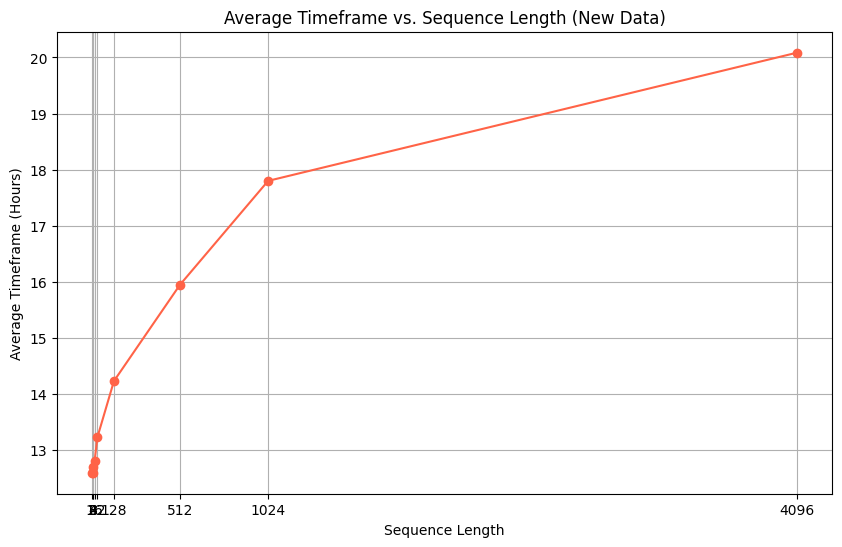

In [63]:
import matplotlib.pyplot as plt

seq_lengths = [2, 4, 8, 16, 32, 128, 512, 1024, 4096]
timeframes_new = [
    0 * 24 + 12 + 36 / 60,
    0 * 24 + 12 + 36 / 60,
    0 * 24 + 12 + 42 / 60,
    0 * 24 + 12 + 49 / 60,
    0 * 24 + 13 + 14 / 60,
    0 * 24 + 14 + 14 / 60,
    0 * 24 + 15 + 57 / 60,
    0 * 24 + 17 + 48 / 60,
    0 * 24 + 20 + 5 / 60
]

total_hours_new = [timeframe for timeframe in timeframes_new]

plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, total_hours_new, marker='o', linestyle='-', color='tomato')
plt.title('Average Timeframe vs. Sequence Length (New Data)')
plt.xlabel('Sequence Length')
plt.ylabel('Average Timeframe (Hours)')
plt.xticks(seq_lengths, seq_lengths)
plt.grid(True)
plt.show()